# K-Means Clustering

In this notebook we would learn the premise of the k-means clustering algorithm. We'd start simple with a small image and make a 3D plot to understand, how the data points in this plot are making natural clusters.

In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

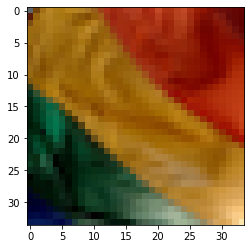

In [26]:
rainbow: np.ndarray = cv2.imread(filename='images/rainbow_icon.png')
rainbow = cv2.cvtColor(src=rainbow, code=cv2.COLOR_BGR2RGB)
plt.imshow(rainbow)

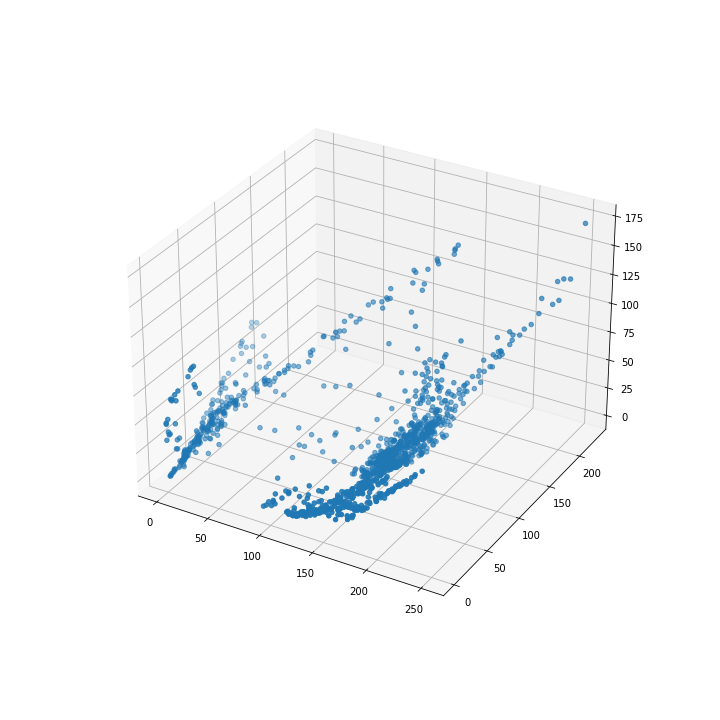

In [27]:
%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(rainbow[:, :, 0], rainbow[:, :, 1], rainbow[:, :, 2])

The plot above should show us, that the data points are making natural clusters. This becomes an intuitive understanding, when we look at the image. We see, that the similar color pixels are closer together in the image space. And in the plot we have scattered the data points from the R, G, and B color channels. So its also natural, that data points making a similar color would also be together. That's what we see in the plot.